In [25]:
import ee
import datetime
import os
import itertools
import sys
import re
import urllib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Prepare basic parameters

In [5]:
# define the years to be classified
year_name  = list([f'{span[0]}_{span[1]}' for span in zip(range(1990,2020,3),range(1992,2020,3)) ])

# define the number of total periods
num_invarient = 10

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
year_name

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

##### Prepare input_image for classification

In [7]:
# prepare the climate data
Climate_type = ['lrad','prec','pres','shum','srad','temp','wind']
Climate_mean = []

for year in range(1990,2019,3):   
    
    # define the three years according to year-variable
    year_start = year
    year_mid   = year + 1
    year_end   = year + 2
    
    # Initiate an empty list to hold the climate-tifs-mean from year_start to year_end
    climate_tifs_mean = []
    
    # compute the mean-tif of each climate-type
    for i in Climate_type:

        # Because cliate_data doesn't include data of 2019, so 
        # use if to exclede the data of year 2019
        if year < 2017:
            climate_tifs = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/{i}/{i}_{t}")                        
                            for t in [year_start,year_mid,year_end]]
            tifs_mean    = ee.ImageCollection(climate_tifs).mean().toFloat().rename(i)

        else:
            climate_tifs = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/{i}/{i}_{t}")                        
                            for t in [year_start,year_mid]]

            tifs_mean    = ee.ImageCollection(climate_tifs).mean().toFloat().rename(i)

        # add all climate_tifs_mean of year_start to year_end to list
        climate_tifs_mean.append(tifs_mean)
        climate_tifs_mean_img = ee.Image(climate_tifs_mean)
        

    # add the mean-cliamte-img into the Climate_mean
    Climate_mean.append(climate_tifs_mean_img)

In [8]:
# import Landsat img
Landsat_img = [ee.Image(f"users/wang8052664/Cloud_Free_Img/Landsat_cloud_free_{year}")\
                 .clip(North_China_Plain)  for year in year_name]

# import Fourier img   
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[:5]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[5:]] 

# Import the Index-mean Img
NDVI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDVI").rename('Mean_NDVI')  
            for year in year_name ]
NDBI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDBI").rename('Mean_NDBI')  
            for year in year_name ]
EVI_img  = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_EVI").rename('Mean_EVI')  
            for year in year_name ]

# Import DEM/SLOPE Img
DEM   = [ee.Image("USGS/SRTMGL1_003").rename('DEM')] * num_invarient
SLOPE = [ee.Terrain.slope(DEM).rename('SLOPE')] * num_invarient

In [9]:
# stack all Imput_Img together
Stack_img = [ee.Image(img) for img in zip(Landsat_img,Fourier_img,NDVI_img,NDBI_img,EVI_img,Climate_mean,DEM,SLOPE)]

##### Prepare input sample points

In [10]:
# Define the path to Sample_pt
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized_Climate'

# Get the training sample
Invarient_training_sample = [ee.FeatureCollection(f"{path}/Invarient_ext_Img_{year}")
                               for year in year_name]

##### Stack input_img and input_sample together

In [11]:
# first put all inputs together
stack_name   = ['Invarient'] * num_invarient

stack_year   = year_name 
stack_img    = Stack_img 
stack_sample = Invarient_training_sample 

# stack all ingredients together
Stack_img_sample = [(stack_name[i],stack_year[i],stack_img[i],stack_sample[i]) for i in range(num_invarient)]

In [12]:
Stack_img_sample

[('Invarient',
  '1990_1992',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82550>),
 ('Invarient',
  '1993_1995',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82d30>),
 ('Invarient',
  '1996_1998',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82c88>),
 ('Invarient',
  '1999_2001',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82cf8>),
 ('Invarient',
  '2002_2004',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82cc0>),
 ('Invarient',
  '2005_2007',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82d68>),
 ('Invarient',
  '2008_2010',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb823c8>),
 ('Invarient',
  '2011_2013',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82e10>),
 ('Invarient',
  '2014_2016',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82e48>),
 ('Invarient',
  '2017_2019',
  <ee.featurecollection.FeatureCollection at 0x1fe7bb82e80>)]

#### Create the classification instances

In [18]:
# A two-layer loop to generate 10-randome-split layers for each year-period

Classificatioin_result = []

# The first-layer loop to go througth each year-periods
for input_variable in Stack_img_sample:
    
    classificaiton_tpye = input_variable[0]
    year                = input_variable[1]
    sample_pt           = input_variable[3]
    input_img           = input_variable[2]
    input_band          = input_img.bandNames().getInfo()

    # The second-layer to go through each-randomnes
    for seed in range(10):
        
        
        #________Instatiate a classification to get the Random_Forest_Classifier using Sector-ID points_____________
        sector = ee.FeatureCollection(f"users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/Sectors_10_Split")\
                   .filterMetadata('Id','equals',seed)
            
        sample = sample_pt.filterBounds(sector)
        
        
        classification = Classification(year_name      = year,
                                        Verified_point = sample,
                                        Input_img      = input_img,
                                        Input_band     = input_band,
                                        Tree_num       = 100,
                                        seed           = seed,
                                        Zone_sample    = None,
                                        classProperty  = 'Built')
        
        # get the random_forest classifier
        RF_classifier = classification.classifier
        
        #__________________________Initiate one more classification-instance for classificatioin______________________
        
        # Get the points that are not used in Sector_ID
        sector_no_equal_id = ee.FeatureCollection(f"users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/Sectors_10_Split")\
                               .filterMetadata('Id','not_equals',seed)
            
        sample_no_equal_id = sample_pt.filterBounds(sector_no_equal_id)
        
        # Merge [sample_no_equal_id] with [Test_sample] of above classification-instance to get Test sample points
        Test_points = classification.Verified_pts_test_with_img_value.merge(sample_no_equal_id)
       

        #______________________________perform the classification on Input_img and Samples_____________________________
        classification.Stp_1_Classification_on_img()
        

        # Get the classified img
        classified_img = classification.classification_img

        # Get the classified samples
        test_sample_classified  = Test_points.classify(RF_classifier)

        # add classfication into the list
        Classificatioin_result.append((classificaiton_tpye,year,seed,classified_img,test_sample_classified))

In [19]:
# convert classificaiton instances into a dataframe
Classification_instances_df =  pd.DataFrame(Classificatioin_result,
                                            columns=['classificaiton_tpye','year','seed','classified_img','test_sample_classified'])
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified
0,Invarient,1990_1992,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
1,Invarient,1990_1992,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
2,Invarient,1990_1992,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
3,Invarient,1990_1992,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
4,Invarient,1990_1992,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
...,...,...,...,...,...
95,Invarient,2017_2019,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
96,Invarient,2017_2019,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
97,Invarient,2017_2019,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
98,Invarient,2017_2019,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."


In [20]:
Classification_instances_df.iloc[0][4].size().getInfo()

21802

#### Get the incorrect classified points

In [21]:
# Diff = Built_val - Classification_val,
# the classification would be incorrect if Diff != 0

def Diff_Built_Classificatioin (fe):
    
    Built_val = ee.Number(fe.get('Built'))
    Classification_val = ee.Number(fe.get('classification'))
    Diff = ee.Number(Built_val).subtract(Classification_val)
                          
    return fe.set('diff',Diff.abs() ) 

In [35]:
# save each year and each random state incorrect pts to csv.

Download_url = []

for t,test_pt,random in Classification_instances_df[['year','test_sample_classified','seed']].values:

    # get the incorrect classified points
    Incorrect_point = test_pt.select('Built','classification')\
                             .map(Diff_Built_Classificatioin)\
                             .filterMetadata('diff','not_equals',0)
    
    # get the download-url
    geemap.ee_to_shp(Incorrect_point,f'C:/Users/wangj/Desktop/New folder (2)/Incorrect_sector_pt_{t}_{random}.shp')
    
    # print out the process
    print(f'Incorrect test points of year {t}_{random}  finished!')

Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1990_1992_0.zip'
Incorrect test points of year 1990_1992_0  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1990_1992_1.zip'
Incorrect test points of year 1990_1992_1  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1990_1992_2.zip'
Incorrect test points of year 1990_1992_2  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1990_1992_3.zip'
I

[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1996_1998_0.zip'
Incorrect test points of year 1996_1998_0  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1996_1998_1.zip'
Incorrect test points of year 1996_1998_1  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1996_1998_2.zip'
Incorrect test points of year 1996_1998_2  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_1996_1998_3.zip'
Incorrect test points of year 1996_1

Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2002_2004_1.zip'
Incorrect test points of year 2002_2004_1  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2002_2004_2.zip'
Incorrect test points of year 2002_2004_2  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2002_2004_3.zip'
Incorrect test points of year 2002_2004_3  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2002_2004_4.zip'
I

[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2008_2010_1.zip'
Incorrect test points of year 2008_2010_1  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2008_2010_2.zip'
Incorrect test points of year 2008_2010_2  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2008_2010_3.zip'
Incorrect test points of year 2008_2010_3  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2008_2010_4.zip'
Incorrect test points of year 2008_2

Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2014_2016_2.zip'
Incorrect test points of year 2014_2016_2  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2014_2016_3.zip'
Incorrect test points of year 2014_2016_3  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2014_2016_4.zip'
Incorrect test points of year 2014_2016_4  finished!
Generating URL ...
Please wait ...
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\wangj\\Desktop\\New folder (2)\\Incorrect_sector_pt_2014_2016_5.zip'
I

#### calculate the accuracy of each radomness

In [15]:
acc = []

# calculate the accuracy of differnet randomness
for i in Classificatioin_result:
    
    accuracy = Accuracy_assesment(i[4]).Stp_1_Calculate_Accuracy()
    acc.append(accuracy)
    
    key = 'Recall_built'
    print(f'{i[1]}_{i[2]}-->Recall_built:{accuracy[key]}')

In [16]:
##store the acc_df to local drive

# acc_df = pd.concat([Classification_instances_df[['year','seed']],pd.DataFrame(acc)],axis=1)
# acc_df.to_csv('./Step_2_Result/Sector_Accuracy.csv',index=False)

# access the acc_df
acc_df = pd.read_csv('./Step_2_Result/Sector_Accuracy.csv',)
acc_df

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,1990_1992,0,94.46,94.79,93.97,95.79,92.57
1,1990_1992,1,92.48,88.48,96.04,95.20,90.37
2,1990_1992,2,87.94,87.01,88.63,85.00,90.21
3,1990_1992,3,87.13,83.11,89.09,78.79,91.53
4,1990_1992,4,91.87,91.86,91.88,85.29,95.65
...,...,...,...,...,...,...,...
95,2017_2019,5,90.20,81.34,92.23,70.54,95.58
96,2017_2019,6,93.70,88.43,95.25,84.58,96.54
97,2017_2019,7,91.40,90.00,92.56,90.97,91.74
98,2017_2019,8,94.16,91.79,96.18,95.35,93.21


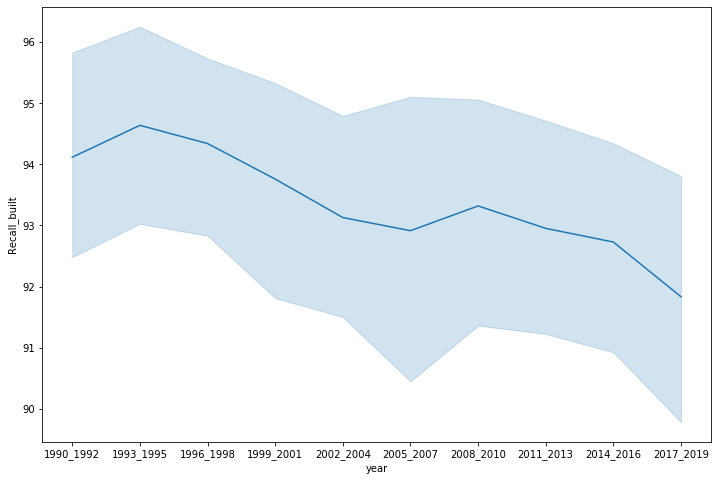

In [28]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='Recall_built',data=acc_df)

##### Export the classified_img

In [19]:
for item in Classificatioin_result:
     
    Classification_type = item[0]
    year = item[1]
    seed = item[2]
    img  = item[3]
    
    
    export_name = f'{Classification_type}_{year}_sector_{seed}'
    
    task = ee.batch.Export.image.toCloudStorage(image          = img,
                                                description    = export_name,
                                                bucket         = 'north_china_plain',
                                                fileNamePrefix = export_name,
                                                region         = North_China_Plain.geometry().bounds(),
                                                scale          = 30,
                                                maxPixels      = int(1e13),
                                                skipEmptyTiles = True)
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Invarient_1990_1992_sector_0 successful!
Exporting Invarient_1990_1992_sector_1 successful!
Exporting Invarient_1990_1992_sector_2 successful!
Exporting Invarient_1990_1992_sector_3 successful!
Exporting Invarient_1990_1992_sector_4 successful!
Exporting Invarient_1990_1992_sector_5 successful!
Exporting Invarient_1990_1992_sector_6 successful!
Exporting Invarient_1990_1992_sector_7 successful!
Exporting Invarient_1990_1992_sector_8 successful!
Exporting Invarient_1990_1992_sector_9 successful!
Exporting Invarient_1993_1995_sector_0 successful!
Exporting Invarient_1993_1995_sector_1 successful!
Exporting Invarient_1993_1995_sector_2 successful!
Exporting Invarient_1993_1995_sector_3 successful!
Exporting Invarient_1993_1995_sector_4 successful!
Exporting Invarient_1993_1995_sector_5 successful!
Exporting Invarient_1993_1995_sector_6 successful!
Exporting Invarient_1993_1995_sector_7 successful!
Exporting Invarient_1993_1995_sector_8 successful!
Exporting Invarient_1993_1995_s

#### Add one of the classified img to map

In [20]:
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified
0,Invarient,1990_1992,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
1,Invarient,1990_1992,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
2,Invarient,1990_1992,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
3,Invarient,1990_1992,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
4,Invarient,1990_1992,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
...,...,...,...,...,...
95,Invarient,2017_2019,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
96,Invarient,2017_2019,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
97,Invarient,2017_2019,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."
98,Invarient,2017_2019,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""..."


In [21]:
one = Classification_instances_df.iloc[0][3]
one

In [29]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(one,{'min':0,'max':1},'One')
Map.addLayer(Classification_instances_df.iloc[6][3],{'min':0,'max':1},'6')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…